<a href="https://colab.research.google.com/github/JairEsc/Aproximaciones-de-Modelos-Epidemiologicos/blob/main/Figuras/bandas_confianza.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

1.9592328071594238 s.  en 50 simulaciones para N=10e4
6.65950345993042 s. en total


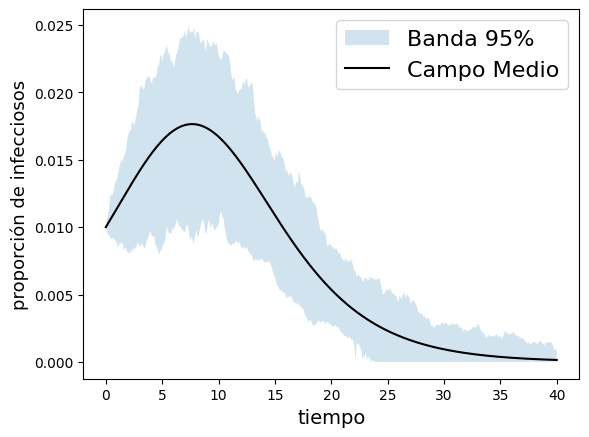

In [13]:
import numpy as np
import matplotlib.pyplot as plt
import time
import pandas as pd

def Gillespie_Markov_Chain_MA(N,S_0,I_0,R_0,beta,gamma,T=np.inf):
  X_S,X_I,X_R=S_0,I_0,R_0
  t=0
  H=[[0,X_S,X_I]]
  while(X_I>0 and t<T):
    lammbda_inf=(beta/N)*X_S*X_I
    lammbda_rec=gamma*X_I
    lammmbda_tol=lammbda_inf+lammbda_rec
    t+=np.random.exponential(scale=1/(lammmbda_tol))
    u_2=np.random.uniform(0,1)
    if(u_2<lammbda_inf/lammmbda_tol):#Infeccion
        X_I+=1
        X_S-=1
    else:#Recuperación
        X_I-=1
        X_R+=1
    H.append([t,X_S,X_I])
  return pd.DataFrame(H,columns=['time','S(t)','I(t)'])
## Ejemplo
start_0=time.time()
np.random.seed(0)
k=50
for power in [4]:
  start_1=time.time()
  beta=1.15
  gamma=1
  N=10**power
  p_i_0=0.01
  I_0=int(p_i_0*N)
  S_0=N-I_0
  R_0=0
  colores=['green','orange','purple']
  Info_bandas=[]
  for iter in range(k):
    if(iter==0):
      H=Gillespie_Markov_Chain_MA(N,S_0,I_0,R_0,beta,gamma,T=40)
    else:
      H=Gillespie_Markov_Chain_MA(N,S_0,I_0,R_0,beta,gamma,T=40)
    Info_bandas.append([H['time'],H['I(t)']/N])
  print(time.time()-start_1, "s.  en "+str(k)+" simulaciones para N=10e"+str(power))
#----------------------------------Campo Medio
from scipy.integrate import odeint
import scipy.integrate as spi
def ode_SIR(INP,t,ps): #Codigo hurtado del dropbox.
    try:
        beta = ps['beta'].value
        gamma = ps['gamma'].value
        N = ps['N'].value
    except:
        beta,gamma,N = ps
    Y = np.zeros((3))
    V = INP
    Y[0] = - beta * V[0] * V[1] /N
    Y[1] = beta * V[0] * V[1]/N - gamma * V[1]
    Y[2] = gamma * V[1]
    return Y
def g(t,INP,ps):
    SOL = spi.odeint(ode_SIR,INPUT,t_range,args=(ps,))
    return SOL[:,1]

INPUT = (S_0, I_0, 0.0)
TT=40
t_start = 0.0; t_end = TT; t_inc = .01
t_range = np.arange(t_start, t_end+t_inc, t_inc)
def suma_por_particion(tiempos,base):
  t_0=0
  R=[]
  ultimo_renglon=0
  for t_i in tiempos:
    #print(t_i)
    cuenta=0
    num_cuentas=0
    while((base['time'][ultimo_renglon]<=t_i)):
      num_cuentas+=1
      cuenta+=base['I(t)/n'][ultimo_renglon]
      if(ultimo_renglon<len(base)-1):
        ultimo_renglon+=1
      else:
        break
    R.append(cuenta/num_cuentas if num_cuentas>0 else 0)
    #print(R)
  return(R)
R_s=[]
t_global=np.linspace(0.0,TT,int(TT*10))
for i in range(k):
  base=pd.DataFrame(np.transpose(Info_bandas[i]),columns=['time','I(t)/n'])
  R_s.append(suma_por_particion(tiempos=t_global,base=base))
R_s=pd.DataFrame(R_s)
mean_by_time=R_s.mean(axis=0)
q_p975=R_s.quantile(0.975,axis=0)
q_p25=R_s.quantile(0.025,axis=0)
fig, ax = plt.subplots()
ax.fill_between(t_global, q_p25, q_p975, alpha=0.2,label='Banda 95%')
print(time.time()-start_0, 's. en total')
plt.plot(t_range,g(t_range,INPUT,[beta,gamma,N])/N, 'k',label='Campo Medio')
#----------------------------------
plt.legend(fontsize=16)
plt.xlabel('tiempo',fontsize=14)
plt.ylabel('proporción de infecciosos',fontsize=13)
#plt.title(r'$n=10^4$')
plt.savefig('banda_e4.png',dpi=300)
plt.show()